Objective of this notebook: 
1.  Understand the data in the various files and document the scope
2.  Comprehend overlaps between train and test data (to understand the intensity of cold start problem if any)
3.  See if user-item interaction matrix can be formulated. - If so, study the sparsity. 
4.  Understand the time duration of the data
5.  Geolocations provided - verify if they are valid

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install pycountry_convert -q
!pip install reverse_geocode -q

     |████████████████████████████████| 10.1 MB 12.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 297 kB 47.5 MB/s 
     |████████████████████████████████| 208 kB 55.2 MB/s 
     |████████████████████████████████| 297 kB 72.9 MB/s 
     |████████████████████████████████| 297 kB 67.8 MB/s 
     |████████████████████████████████| 296 kB 74.0 MB/s 
     |████████████████████████████████| 296 kB 64.9 MB/s 
     |████████████████████████████████| 280 kB 74.5 MB/s 
     |████████████████████████████████| 280 kB 60.1 MB/s 
     |████████████████████████████████| 280 kB 60.9 MB/s 
     |████████████████████████████████| 280 kB 47.5 MB/s 
     |████████████████████████████████| 279 kB 46.5 MB/s 
     |████████████████████████████████| 279 kB 79.3 MB/s 
     |████████████████████████████████| 272 kB 60.8 MB/s 
     |████████████████████████████████| 272 kB 76.7 MB/s 
   

##Understand the data

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [ ]:
with open("/content/drive/MyDrive/kaggle_data/VariableDefinitions.txt") as intro_file:
  print(intro_file.read())

Train Customers


Information on the customers in the training set. 


'akeed_customer_id': Unique customer ID, used in train_locations and train_orders
'gender': Customer gender
'dob': Birth Year (if entered)
'status' and 'verified': Account status
'language': Chosen language
'Created_at' and 'updated_at': dates when account was created/updated


Train Locations


Each customer orders from one or more locations. Each is assigned a location number. 
'customer_id': The unique customer ID 
'location_number': Location number (most customers have one or two)
'location_type': Home, Work, Other or NA
'Latitude' and 'longitude': Not true latitude and longitude - locations have been masked, but nearby locations remain nearby in the new reference frame and can thus be used for clustering. However, not all locations are useful due to GPS errors and missing data - you may want to treat outliers separately.


Train Orders


This is a record of all orders made by customers in the train set from the

##train_customers & test_customers

1. Read the files and convert timestamp or date fields to appropriate formats (datetime64 type)
2. Check for duplicate customer_ids and understand the reason for duplicates

1. Read the files and convert timestamp or date fields to appropriate formats (datetime64 type)

In [ ]:
train_customers=pd.read_csv("/content/drive/MyDrive/kaggle_data/train_customers.csv")
test_customers=pd.read_csv("/content/drive/MyDrive/kaggle_data/test_customers.csv")

train_customers["updated_at"] = pd.to_datetime(train_customers["updated_at"])
train_customers["created_at"] = pd.to_datetime(train_customers["created_at"])
test_customers["updated_at"] = pd.to_datetime(test_customers["updated_at"])
test_customers["created_at"] = pd.to_datetime(test_customers["created_at"])

2. Check for duplicate customer_id in both train and test dataset. 

In [ ]:
print("train_customers",sum(train_customers.duplicated("akeed_customer_id")))
print("test_customers",sum(test_customers.duplicated("akeed_customer_id")))

train_customers 151
test_customers 15


As there are duplicates, peek into the duplicate customer records and get the count of duplicate entries for each customer_id (add 1 to these)

In [ ]:
dup_cnt = train_customers[train_customers.duplicated("akeed_customer_id")]["akeed_customer_id"].value_counts()
dups = dup_cnt.reset_index()
dups.columns=["akeed_customer_id","duplicate_count"]
dups.head(5)

,akeed_customer_id,duplicate_count
0,0FOCFVI,16
1,H0GVNAK,15
2,XFQVCSZ,8
3,U0SUJYS,6
4,QT5BMDP,6


Are there multiple 'verified' records for a customer?

Answer: There is only one verified record for customers having duplicate records in both train and test set. Hence prior to verifying the customer, there were multiple updates to the customer record.

In [ ]:
print("Are there multiple 'verified' records for any train customer?",train_customers[train_customers.duplicated("akeed_customer_id") & (train_customers["verified"] == 1)]["akeed_customer_id"].value_counts().shape[0])
print("Are there multiple 'verified' records for any test customer?",test_customers[test_customers.duplicated("akeed_customer_id") & (test_customers["verified"] == 1)]["akeed_customer_id"].value_counts().shape[0])

Are there multiple 'verified' records for any train customer? 0
Are there multiple 'verified' records for any test customer? 0


Reason for duplicates:
Updated ts are different. The last updated one has the verified column set.

In [ ]:
train_customers[train_customers["akeed_customer_id"] == "PB7GZR8"]

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
23709,PB7GZR8,Female,2001.0,1,1,NaN,2019-11-19 20:03:23,2019-11-19 20:05:37
23710,PB7GZR8,male,NaN,1,0,NaN,2019-11-19 20:03:26,2019-11-19 20:03:26


Extract the last updated records for all customers


In [ ]:
train_customers_dedup = train_customers[train_customers["updated_at"] == train_customers.groupby(["akeed_customer_id"])['updated_at'].transform('max')]
print(train_customers_dedup.shape)

test_customers_dedup = test_customers[test_customers["updated_at"] == test_customers.groupby(["akeed_customer_id"])['updated_at'].transform('max')]
print(test_customers_dedup.shape)

(34523, 8)
(9753, 8)


Are all customers verified?

Answer: There are few customers who are still not verified.

In [ ]:
print("Train - Verified Customers vs Non-verified customers",train_customers_dedup[train_customers_dedup["verified"] == 1].shape[0],train_customers_dedup[train_customers_dedup["verified"] == 0].shape[0])
print("Test - Verified Customers vs Non-verified customers",test_customers_dedup[test_customers_dedup["verified"] == 1].shape[0],test_customers_dedup[test_customers_dedup["verified"] == 0].shape[0])
print("Total train customers after removing duplicate records",train_customers_dedup.shape)
print("Total test customers after removing duplicate records",test_customers_dedup.shape)

Train - Verified Customers vs Non-verified customers 33158 1365
Test - Verified Customers vs Non-verified customers 9332 421
Total train customers after removing duplicate records (34523, 8)
Total test customers after removing duplicate records (9753, 8)


Verify if the customers are overlapping between train and test data

Answer: There is no overlap between train and test customers

In [ ]:
print(len(set(train_customers_dedup["akeed_customer_id"]).intersection(set(test_customers_dedup["akeed_customer_id"]))))

0


Check for volume of nans in dob field in both train and test

Outcomes:
*  91% of train customers and 91% of test customer have null values in the dob attribute. Hence dob cannot be a useful feature in profiling customers.
*  Only 38% of train customers and 39% of test customer have null values in the language attribute. null values will hence be treated as the second category.
* None of the 'status' and 'verified' attributes have null values.
* 99.9% of the train and test customers have single value for 'status' attribute. Hence this feature will not add any value.
* 96% of the train and test customers have single value for 'verified' attribute.

In [ ]:
print("Total number of train_customers",train_customers_dedup.shape[0])
print("Total number of test_customers",test_customers_dedup.shape[0])
print(" ")

print("Number of train customers without dob info {} ({:.2f}%)".format(train_customers_dedup["dob"].isna().sum(),100*train_customers_dedup["dob"].isna().sum()/train_customers_dedup.shape[0])) 
print("Number of test customers without dob info {} ({:.2f}%)".format(test_customers_dedup["dob"].isna().sum(),100*test_customers_dedup["dob"].isna().sum()/test_customers_dedup.shape[0])) 
print(" ")

print("Number of train customers without language info {} ({:.2f}%)".format(train_customers_dedup["language"].isna().sum(),100*train_customers_dedup["language"].isna().sum()/train_customers_dedup.shape[0]))
print("Number of test customers without language info {} ({:.2f}%)".format(test_customers_dedup["language"].isna().sum(),100*test_customers_dedup["language"].isna().sum()/test_customers_dedup.shape[0]))
print("Languages spoken by train customers",pd.unique(train_customers_dedup["language"]))
print("Languages spoken by test customers",pd.unique(test_customers_dedup["language"]))
print(" ")

print("Number of train customers without status info",train_customers_dedup["status"].isna().sum())
print("Number of test customers without status info",test_customers_dedup["status"].isna().sum())
print(" ")
print("Number of train customers without status info",train_customers_dedup["verified"].isna().sum())
print("Number of test customers without status info",test_customers_dedup["verified"].isna().sum())
print(" ")
print("Statuses of train customers\n",train_customers_dedup["status"].value_counts())
print(" ")
print("Statuses of test customers\n",test_customers_dedup["status"].value_counts())
print(" ")
print("Verification values of train customers\n",train_customers_dedup["verified"].value_counts())
print(" ")
print("Verification values of test customers\n",test_customers_dedup["verified"].value_counts())

Total number of train_customers 34523
Total number of test_customers 9753
 
Number of train customers without dob info 31477 (91.18%)
Number of test customers without dob info 8905 (91.31%)
 
Number of train customers without language info 13424 (38.88%)
Number of test customers without language info 3825 (39.22%)
Languages spoken by train customers ['EN' nan]
Languages spoken by test customers ['EN' nan]
 
Number of train customers without status info 0
Number of test customers without status info 0
 
Number of train customers without status info 0
Number of test customers without status info 0
 
Statuses of train customers
 1    34495
0       28
Name: status, dtype: int64
 
Statuses of test customers
 1    9743
0      10
Name: status, dtype: int64
 
Verification values of train customers
 1    33158
0     1365
Name: verified, dtype: int64
 
Verification values of test customers
 1    9332
0     421
Name: verified, dtype: int64


In [ ]:
print("Number of train customers without gender info",train_customers_dedup["gender"].isna().sum())
print("Number of test customers without gender info",test_customers_dedup["gender"].isna().sum())
print("Genders in train customers",pd.unique(train_customers_dedup["gender"]))
print("Genders in test customers",pd.unique(test_customers_dedup["gender"]))
print("Number of train customers with incorrect gender info",train_customers_dedup[train_customers_dedup["gender"]== '?????'].shape)
print(" ")

Number of train customers without gender info 12154
Number of test customers without gender info 3447
Genders in train customers ['Male' 'Female' 'Female  ' 'Female   ' 'Female    ' 'Male  ' '  '
 'Female ' nan '?????' 'male']
Genders in test customers ['Male' 'Female' 'Female  ' 'Female ' 'Male  ' nan 'male']
Number of train customers with incorrect gender info (2, 8)
 


Fix values for the gender attribute

In [ ]:
#remove trailing spaces and convert to lower case
train_customers_dedup.loc[:,"gender"] = train_customers_dedup["gender"].astype("str").str.rstrip().str.lower()
test_customers_dedup.loc[:,"gender"] = test_customers_dedup["gender"].astype("str").str.rstrip().str.lower()

#fix missing and incorrect values as 'unknown'
train_customers_dedup.loc[~train_customers_dedup["gender"].isin(["male","female"]),"gender"] = "unknown"
test_customers_dedup.loc[~test_customers_dedup["gender"].isin(["male","female"]),"gender"] = "unknown"

print("Unique values of gender attribute for train customer post fix",pd.unique(train_customers_dedup["gender"]))
print("Unique values of gender attribute for test customer post fix",pd.unique(test_customers_dedup["gender"]))

Unique values of gender attribute for train customer post fix ['male' 'female' 'unknown']
Unique values of gender attribute for test customer post fix ['male' 'female' 'unknown']


In [ ]:
print("Train customer gender distribution",train_customers_dedup["gender"].value_counts())
print("Test customer gender distribution",test_customers_dedup["gender"].value_counts())

Train customer gender distribution male       20587
unknown    12157
female      1779
Name: gender, dtype: int64
Test customer gender distribution male       5784
unknown    3447
female      522
Name: gender, dtype: int64


##train_locations & test_locations

In [ ]:
train_locations=pd.read_csv("/content/drive/MyDrive/kaggle_data/train_locations.csv")
test_locations=pd.read_csv("/content/drive/MyDrive/kaggle_data/test_locations.csv")
print("train_locations",train_locations.shape)
print("test_locations",test_locations.shape)
print("Null values in train_locations",train_locations.isna().sum())
print("Null values in test_locations",test_locations.isna().sum())
print(train_locations.head())

train_locations (59503, 5)
test_locations (16720, 5)
Null values in train_locations customer_id            0
location_number        0
location_type      27209
latitude               6
longitude              6
dtype: int64
Null values in test_locations customer_id           0
location_number       0
location_type      7650
latitude              3
longitude             3
dtype: int64
  customer_id  location_number location_type  latitude  longitude
0     02SFNJH                0           NaN  1.682392 -78.789737
1     02SFNJH                1           NaN  1.679137   0.766823
2     02SFNJH                2           NaN -0.498648   0.661241
3     RU43CXC                0          Home  0.100853   0.438165
4     BDFBPRD                0           NaN  2.523125   0.733464


Highest number of locations a customer orders from in the train set - 30, 26, 20, 19

Highest number of locations a customer orders from in the test set - 12, 11, 10, 9

Verify if the customer-location combo has duplicate entries

Unique customer-location combo is identified using "customer_id","location_number" columns

In [ ]:
print("train_locations",sum(train_locations.duplicated(["customer_id","location_number"])))
print("test_locations",sum(test_locations.duplicated(["customer_id","location_number"])))

train_locations 0
test_locations 0


Check if all customers in demographics data are present in customer-location file

In [ ]:
print("Number of customers in train_customers: ", len(set(train_customers["akeed_customer_id"])))
print("Number of customers in train_locations: ", len(set(train_locations["customer_id"])))
print("Number of customers in train_locations without Demographics data: ",len(set(train_locations["customer_id"]).difference(set(train_customers["akeed_customer_id"])) ))

Number of customers in train_customers:  34523
Number of customers in train_locations:  35400
Number of customers in train_locations without Demographics data:  877


In [ ]:
print("Number of customers in test_customers: ", len(set(test_customers["akeed_customer_id"])))
print("Number of customers in test_locations: ", len(set(test_locations["customer_id"])))
print("Number of customers in test_locations without Demographics data: ",len(set(test_locations["customer_id"]).difference(set(test_customers["akeed_customer_id"])) ))

Number of customers in test_customers:  9753
Number of customers in test_locations:  10000
Number of customers in test_locations without Demographics data:  247


**Analyse missing coordinates in train_locations**

Retrieve customer locations whose latitude or longitude coordinates of any location is null

There are 19 customer locations with missing latitude and longitude

In [ ]:
print("Number of train customer locations with missing coordinates",train_locations[train_locations["customer_id"].isin(list(train_locations[train_locations["latitude"].isna()]["customer_id"]))].shape)
print("Train customers with atleast one location with missing coordinates",list(train_locations[train_locations["latitude"].isna()]["customer_id"])) #those customers with any null coordinate locations
print(" ")
print("Number of test customer locations with missing coordinates",test_locations[test_locations["customer_id"].isin(list(test_locations[test_locations["latitude"].isna()]["customer_id"]))].shape)
print("Test customers with atleast one location with missing coordinates",list(test_locations[test_locations["latitude"].isna()]["customer_id"])) #those customers with any null coordinate locations

Number of train customer locations with missing coordinates (19, 5)
Train customers with atleast one location with missing coordinates ['7URX8JP', 'NSQRO1H', '55MCNEF', 'VZIK43C', 'QFWLNUK', 'O0LALCF']
 
Number of test customer locations with missing coordinates (9, 5)
Test customers with atleast one location with missing coordinates ['MTIT5P2', '4F7FKH4', '4XGAZYS']


**Understand the geography represented by the coordinates**

1. Extract those locations with valid latitude and longitude values.

  * latitude lies between -90 to 90
  * longitude lies between -180 to 180

2. Remove those with null values

3. Retrieve the city and country of those coordinates and check the density of the values. The data belongs to the geography with most number of points.

4. Retrieve city and country of the vendor coordinates. Vendors in the same geography can serve customers in the neighbouring geography.

https://datascientyst.com/reverse-geocoding-latitude-longitude-city-country-python-pandas/

In [ ]:
import reverse_geocode
import pycountry_convert as pc
import time

train_locations_valid = train_locations[(((train_locations["latitude"] >= -90.0) & (train_locations["latitude"] <= 90.0)) & ((train_locations["longitude"] >= -180.0) & (train_locations["longitude"] <= 180.0)))]
train_locations_valid = train_locations_valid[~train_locations_valid["latitude"].isna()]
print("***********       TRAIN LOCATIONS      ************")
print("Total train location records",train_locations.shape[0])
print("Valid train location records",train_locations_valid.shape[0],"\n")

coordinates = list(zip(train_locations_valid["latitude"],train_locations_valid["longitude"]))
train_locations_valid[["country_code","city","country"]] = pd.DataFrame(reverse_geocode.search(coordinates))

country_codes = train_locations_valid["country_code"].dropna().unique()
country_continent_map = {country_code : pc.convert_continent_code_to_continent_name(pc.country_alpha2_to_continent_code(country_code)) 
                                    for country_code in country_codes}
train_locations_valid["country_code"].fillna("Invalid",inplace=True)
country_continent_map['null'] = 'Invalid'
train_locations_valid['continent'] = train_locations_valid['country_code'].map(country_continent_map)

print("Set of countries in train locations",pd.unique(train_locations_valid["country"]),"\n")
print(train_locations_valid["country"].value_counts(),"\n")
print("***********       TEST LOCATIONS      ************")

test_locations_valid = test_locations[(((test_locations["latitude"] >= -90.0) & (test_locations["latitude"] <= 90.0)) & ((test_locations["longitude"] >= -180.0) & (test_locations["longitude"] <= 180.0)))]
test_locations_valid = test_locations_valid[~test_locations_valid["latitude"].isna()]

print("Total test location records",test_locations.shape[0])
print("Valid test location records",test_locations_valid.shape[0],"\n")

coordinates = list(zip(test_locations_valid["latitude"],test_locations_valid["longitude"]))
test_locations_valid[["country_code","city","country"]] = pd.DataFrame(reverse_geocode.search(coordinates))

print("Set of countries in train locations",pd.unique(test_locations_valid["country"]),"\n")
print(test_locations_valid["country"].value_counts(),"\n")

***********       TRAIN LOCATIONS      ************
Total train location records 59503
Valid train location records 58169 

Set of countries in train locations ['Colombia' 'Ghana' 'Equatorial Guinea' 'Burkina Faso' 'Ecuador' 'Mali'
 'Saint Helena' 'Algeria' nan] 

Equatorial Guinea    18943
Ecuador              17853
Ghana                17721
Burkina Faso           838
Colombia               731
Mali                   484
Saint Helena           294
Algeria                  1
Name: country, dtype: int64 

***********       TEST LOCATIONS      ************
Total test location records 16720
Valid test location records 16341 

Set of countries in train locations ['Ecuador' 'Equatorial Guinea' 'Ghana' 'Mali' 'Burkina Faso' 'Colombia'
 'Saint Helena' nan] 

Equatorial Guinea    5299
Ecuador              5057
Ghana                4957
Burkina Faso          225
Colombia              200
Mali                  154
Saint Helena           78
Name: country, dtype: int64 



In [ ]:
loc_cnt = train_locations.groupby(["customer_id"])["location_number"].count().reset_index()
loc_cnt.sort_values("location_number",ascending=False,inplace=True)
loc_cnt

,customer_id,location_number
4803,4Y0K8NQ,30
22986,NETYQ1C,26
5270,5EP9F62,20
4718,4UZKXW2,19
34323,YYKZN0F,19
...,...,...
14687,F10W1P0,1
14686,F0ZD7R4,1
14683,F0SP5DL,1
14681,F0PCZ53,1


Text(0, 0.5, 'Number of customers')

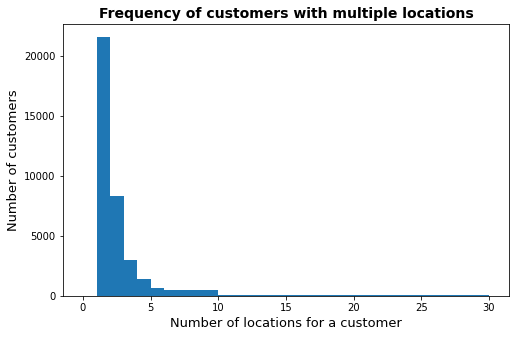

In [ ]:
#Count of locations per customer
plt.figure(figsize=(8,5))
loc_cnt = train_locations.groupby(["customer_id"])["location_number"].count().reset_index()
loc_cnt.sort_values("location_number",ascending=False,inplace=True)
plt.hist(loc_cnt["location_number"],bins=[0,1,2,3,4,5,6,10,30]) #there are maximum 30 values for a single customer
plt.title("Frequency of customers with multiple locations",fontsize=14, fontweight ="bold")
plt.xlabel("Number of locations for a customer",fontsize=13)
plt.ylabel("Number of customers",fontsize=13)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

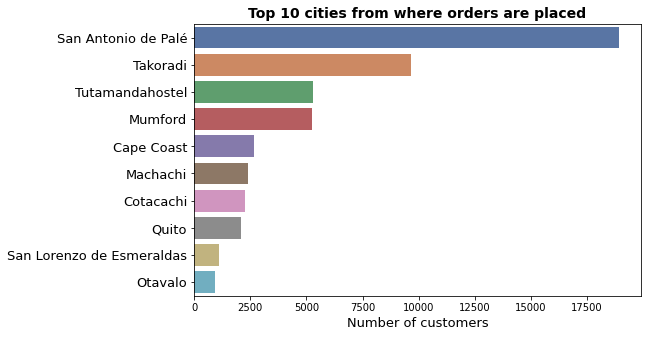

In [ ]:

#Top 10 cities from where orders are placed
plt.figure(figsize=(8,5))
country_counts=train_locations_valid['city'].value_counts()[:10]
sns.barplot(x=country_counts,y=country_counts.index,palette='deep')
plt.title("Top 10 cities from where orders are placed",fontsize=14, fontweight ="bold")
plt.xlabel("Number of customers",fontsize=13)
plt.yticks(fontsize=13)


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

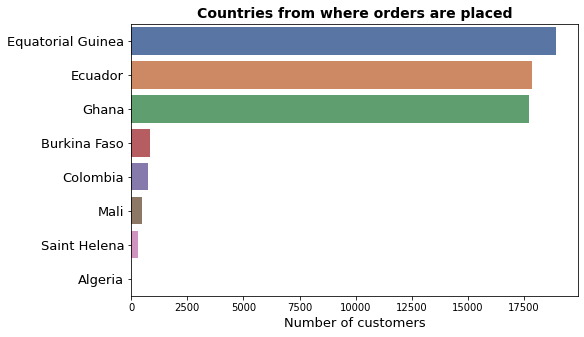

In [ ]:
#Countries from where orders are placed
plt.figure(figsize=(8,5))
country_counts=train_locations_valid['country'].value_counts()
sns.barplot(x=country_counts,y=country_counts.index,palette='deep')
plt.title("Countries from where orders are placed",fontsize=14,fontweight ="bold")
plt.xlabel("Number of customers",fontsize=13)
plt.yticks(fontsize=13)

Text(0.5, 1.0, 'Continents from where orders are placed')

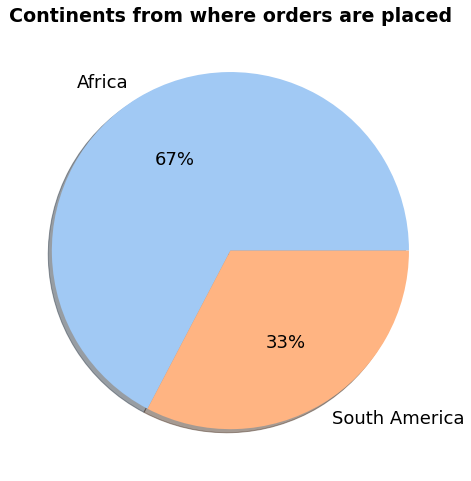

In [ ]:

#Distibution of locations across continents 
plt.figure(figsize=(8,15))
continent_counts=train_locations_valid['continent'].value_counts()
# Seaborn color palette to plot pie chart
colors = sns.color_palette('pastel')
plt.pie(x=continent_counts,labels=continent_counts.index,colors=colors,autopct='%.0f%%', shadow=True,textprops={'fontsize': 18})
plt.title("Continents from where orders are placed",fontsize=19,fontweight ="bold")

###Based on above statistics, the customers locations primarly are in Africa and South America. 

Is it **across continents?** Lets verify by looking into vendor locations 

Country - Continent - train_locations - test_locations

---


Equatorial Guinea  - Central Africa - 19371 - 5416

Ecuador - South America - 18260 - 5178

Ghana - West Africa  - 18149 - 5075

Burkina Faso  - West Africa - 851 - 226

Colombia - South America, adjacent to Ecuador. - 745 - 206
 
Mali - West Africa - 494 - 162

Saint Helen - 1200 miles west of South Africa cost - 298 - 78

**Update after verifying coordinates in vendor files:**

Vendor Locations are **only in Africa**. Hence the coordinates corresponding to South American countries and Saint Helen must be incorrect.

Vendors file consists of vendor details and his attributes (shop location, category, deliver charge, distance threshold for delivery, timings, food specialities)

Plot latitude and longitude to validate the locations

In [ ]:
print(train_locations["latitude"].mean())
print(train_locations["longitude"].mean())

2.3611346798741386
-25.11541020024208


Reference: https://towardsdatascience.com/creating-a-simple-map-with-folium-and-python-4c083abfff94

https://skelouse.github.io/faster_mapping_with_folium

In [ ]:
import folium
cust_map = folium.Map(location=[0,0],width='95%',height='70%',zoom_start=2, prefer_canvas=True,max_zoom=9,min_zoom=3,zoom_control=False)
for i in list(np.random.choice(train_locations_valid.index,10000)):
    folium.Circle([train_locations_valid.loc[i, 'latitude'], train_locations_valid.loc[i, 'longitude']],radius=10).add_to(cust_map)

sw = train_locations_valid[['latitude', 'longitude']].min().values.tolist()
ne = train_locations_valid[['latitude', 'longitude']].max().values.tolist()

cust_map.fit_bounds([sw, ne]) 
cust_map

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
vendors=pd.read_csv("/content/drive/MyDrive/kaggle_data/vendors.csv")
vendors["id"] = vendors["id"].astype('str')
print("vendors",vendors.shape) #
print("Vendor Categories",pd.unique(vendors["vendor_category_en"]))
vendors.head()

vendors (100, 59)
Vendor Categories ['Restaurants' 'Sweets & Bakes']


,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,OpeningTime2,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,tuesday_from_time2,tuesday_to_time2,wednesday_from_time1,wednesday_to_time1,wednesday_from_time2,wednesday_to_time2,thursday_from_time1,thursday_to_time1,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2,primary_tags,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,-,15,0.0,Yes,0.0,1.0,1,11,EN,4.4,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,10:00:00,23:59:00,00:00:00,00:30:00,10:00:00,23:59:00,"{""primary_tags"":""4""}",1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,-,14,0.0,Yes,0.0,1.0,1,11,EN,4.7,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,19:30:00,00:00:00,01:30:00,08:00:00,19:30:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,"{""primary_tags"":""7""}",1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
2,20,118616.0,-0.407527,0.643681,Restaurants,2.0,0.0,8.0,1.0,08:00AM-10:45PM,-,19,0.0,Yes,0.0,1.0,1,1,EN,4.5,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,"{""primary_tags"":""71""}",1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
3,23,118619.0,-0.585385,0.753811,Restaurants,2.0,0.0,5.0,1.0,10:59AM-10:30PM,-,16,0.0,Yes,0.0,1.0,1,11,EN,4.5,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN,"{""primary_tags"":""46""}",1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
4,28,118624.0,0.480602,0.552850,Restaurants,2.0,0.7,15.0,1.0,11:00AM-11:45PM,-,10,0.0,Yes,0.0,1.0,1,11,EN,4.4,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,01:30:00,17:45:00,23:59:00,00:01:00,01:30:00,17:45:00,23:59:00,"{""primary_tags"":""32""}",1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1


Verify vendor locations
 * All the vendor locations are in Africa except for 1 which has incorrect coordinate values

In [ ]:
vendors_valid = vendors[(((vendors["latitude"] >= -90.0) & (vendors["latitude"] <= 90.0)) & ((vendors["longitude"] >= -180.0) & (vendors["longitude"] <= 180.0)))]
vendors_valid = vendors_valid[~vendors_valid["latitude"].isna()]
print("Total vendors",vendors.shape[0])
print("Valid vendor locations",vendors_valid.shape[0],"\n")

coordinates = list(zip(vendors_valid["latitude"],vendors_valid["longitude"]))
vendors_valid[["country_code","city","country"]] = pd.DataFrame(reverse_geocode.search(coordinates))
print("Countries of the vendor locations",pd.unique(vendors_valid["country"]),"\n")
print(vendors_valid["country"].value_counts())

Total vendors 100
Valid vendor locations 99 

Countries of the vendor locations ['Equatorial Guinea' 'Ghana' 'Burkina Faso' nan] 

Equatorial Guinea    79
Ghana                18
Burkina Faso          1
Name: country, dtype: int64


Extract the vendor info with incorrect coordinates

* It is vendor_id 231

In [ ]:
vendors_invalid = vendors[~vendors["id"] .isin(vendors_valid["id"])]
vendors_invalid

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,OpeningTime2,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,tuesday_from_time2,tuesday_to_time2,wednesday_from_time1,wednesday_to_time1,wednesday_from_time2,wednesday_to_time2,thursday_from_time1,thursday_to_time1,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2,primary_tags,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
55,231,118830.0,205.242327,44.210807,Sweets & Bakes,3.0,0.7,10.0,1.0,9am-10pm,10pm-11pm,15,0.0,Yes,0.0,1.0,1,11,EN,4.3,NaN,NaN,NaN,NaN,09:00:00,21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,10:00:00,16:01:00,17:00:00,23:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Y,1.0,1.0,2019-04-24 20:04:18,2020-03-20 09:45:15,1,1


**Vendor features analysis**


Get unique values of all vendor features and features with single value can be dropped

Since customer's ordered date and time are not available, day specific working hours are not considered

In [ ]:
print("Total number of vendor_rating: ",len(pd.unique(vendors['vendor_rating'])),"\nvendor_rating",pd.unique(vendors['vendor_rating']))
print("Total number of sunday_from_time1: ",len(pd.unique(vendors['sunday_from_time1'])),"\sunday_from_time1",pd.unique(vendors['sunday_from_time1']))
print("Total number of sunday_to_time1: ",len(pd.unique(vendors['sunday_to_time1'])),"\nsunday_to_time1",pd.unique(vendors['sunday_to_time1']))
print("Total number of sunday_from_time2: ",len(pd.unique(vendors['sunday_from_time2'])),"\nsunday_from_time2",pd.unique(vendors['sunday_from_time2']))
print("Total number of sunday_to_time2: ",len(pd.unique(vendors['sunday_to_time2'])),"\nsunday_to_time2",pd.unique(vendors['sunday_to_time2']))
print("Total number of monday_from_time1: ",len(pd.unique(vendors['monday_from_time1'])),"\nmonday_from_time1",pd.unique(vendors['monday_from_time1']))
print("Total number of monday_to_time1: ",len(pd.unique(vendors['monday_to_time1'])),"\nmonday_to_time1",pd.unique(vendors['monday_to_time1']))
print("Total number of monday_from_time2: ",len(pd.unique(vendors['monday_from_time2'])),"\nmonday_from_time2",pd.unique(vendors['monday_from_time2']))
print("Total number of monday_to_time2: ",len(pd.unique(vendors['monday_to_time2'])),"\nmonday_to_time2",pd.unique(vendors['monday_to_time2']))

Total number of vendor_rating:  12 
vendor_rating [4.4 4.7 4.5 4.6 4.3 4.  3.8 4.2 4.8 3.2 4.1 3.7]
Total number of sunday_from_time1:  20 \sunday_from_time1 ['00:00:00' '08:00:00' '09:00:00' '00:01:00' '10:00:00' '11:00:00'
 '11:59:00' '08:30:00' '13:00:00' '11:15:00' '11:45:00' '11:05:00'
 '13:30:00' '11:30:00' nan '14:00:00' '12:00:00' '10:45:00' '12:20:00'
 '17:00:00']
Total number of sunday_to_time1:  28 
sunday_to_time1 ['00:30:00' '01:30:00' '22:45:00' '23:30:00' '23:59:00' '23:00:00'
 '21:45:00' '22:30:00' '21:30:00' '02:00:00' '23:45:00' '00:59:00'
 '00:45:00' '22:00:00' '00:15:00' '15:30:00' '22:25:00' '01:15:00'
 '15:45:00' '19:00:00' nan '13:30:00' '15:00:00' '20:00:00' '16:00:00'
 '16:40:00' '23:15:00' '12:30:00']
Total number of sunday_from_time2:  17 
sunday_from_time2 ['08:00:00' nan '11:00:00' '00:00:00' '18:00:00' '10:00:00' '11:59:00'
 '11:30:00' '12:30:00' '18:30:00' '09:15:00' '15:00:00' '14:00:00'
 '16:00:00' '17:00:00' '08:15:00' '16:30:00']
Total number of sunda

In [ ]:
print("Total number of prepration_time: ",len(pd.unique(vendors['prepration_time'])),"\nprepration_time",pd.unique(vendors['prepration_time']))
print("Total number of commission: ",len(pd.unique(vendors['commission'])),"\ncommission",pd.unique(vendors['commission']))
print("Total number of is_akeed_delivering: ",len(pd.unique(vendors['is_akeed_delivering'])),"\nis_akeed_delivering",pd.unique(vendors['is_akeed_delivering']))
print("Total number of discount_percentage: ",len(pd.unique(vendors['discount_percentage'])),"\ndiscount_percentage",pd.unique(vendors['discount_percentage']))
print("Total number of status: ",len(pd.unique(vendors['status'])),"\nstatus",pd.unique(vendors['status']))
print("Total number of verified: ",len(pd.unique(vendors['verified'])),"\nverified",pd.unique(vendors['verified']))
print("Total number of rank: ",len(pd.unique(vendors['rank'])),"\nrank",pd.unique(vendors['rank']))
print("Total number of language: ",len(pd.unique(vendors['language'])),"\nlanguage",pd.unique(vendors['language']))

Total number of prepration_time:  14 
prepration_time [15 14 19 16 10 17 20 11 13 12 18 21 45  5]
Total number of commission:  2 
commission [ 0. nan]
Total number of is_akeed_delivering:  1 
is_akeed_delivering ['Yes']
Total number of discount_percentage:  5 
discount_percentage [ 0. 10. 50. 35. 15.]
Total number of status:  2 
status [1. 0.]
Total number of verified:  2 
verified [1 0]
Total number of rank:  2 
rank [11  1]
Total number of language:  2 
language ['EN' nan]


In [ ]:
print("Languages: ",len(pd.unique(vendors['language'])),"\language",pd.unique(vendors['language']))
print("Frequency of Languages: ",vendors['language'].value_counts())

Languages:  2 \language ['EN' nan]
Frequency of Languages:  EN    85
Name: language, dtype: int64


In [ ]:
print("Total number of vendor_category_en: ",len(pd.unique(vendors['vendor_category_en'])),"\vendor_category_en",pd.unique(vendors['vendor_category_en']))
print("Total number of vendor_category_en: ",vendors['vendor_category_en'].value_counts())
print("Total number of vendor_category_id: ",len(pd.unique(vendors['vendor_category_id'])),"\vendor_category_id",pd.unique(vendors['vendor_category_id']))
print("Total number of vendor_category_en: ",vendors['vendor_category_id'].value_counts())

Total number of vendor_category_en:  2 endor_category_en ['Restaurants' 'Sweets & Bakes']
Total number of vendor_category_en:  Restaurants       88
Sweets & Bakes    12
Name: vendor_category_en, dtype: int64
Total number of vendor_category_id:  2 endor_category_id [2. 3.]
Total number of vendor_category_en:  2.0    89
3.0    11
Name: vendor_category_id, dtype: int64


In [ ]:
print("Total number of primary_tag: ",len(pd.unique(vendors['primary_tags'])),"\primary_tag",pd.unique(vendors['primary_tags']))

Total number of primary_tag:  43 \primary_tag ['{"primary_tags":"4"}' '{"primary_tags":"7"}' '{"primary_tags":"71"}'
 '{"primary_tags":"46"}' '{"primary_tags":"32"}' '{"primary_tags":"51"}'
 '{"primary_tags":"8"}' '{"primary_tags":"21"}' '{"primary_tags":"271"}'
 '{"primary_tags":"129"}' nan '{"primary_tags":"24"}'
 '{"primary_tags":"323"}' '{"primary_tags":"134"}' '{"primary_tags":"90"}'
 '{"primary_tags":"336"}' '{"primary_tags":"31"}' '{"primary_tags":"462"}'
 '{"primary_tags":"138"}' '{"primary_tags":"534"}'
 '{"primary_tags":"297"}' '{"primary_tags":"35"}' '{"primary_tags":"695"}'
 '{"primary_tags":"701"}' '{"primary_tags":"270"}' '{"primary_tags":"52"}'
 '{"primary_tags":"815"}' '{"primary_tags":"849"}'
 '{"primary_tags":"346"}' '{"primary_tags":"47"}' '{"primary_tags":"28"}'
 '{"primary_tags":"180"}' '{"primary_tags":"204"}'
 '{"primary_tags":"260"}' '{"primary_tags":"1088"}'
 '{"primary_tags":"478"}' '{"primary_tags":"1065"}'
 '{"primary_tags":"1147"}' '{"primary_tags":"1348"}'

In [ ]:
vendors["primary_tags_mod"] = vendors["primary_tags"].str.split('{"primary_tags":"').str[1].str.split('"}').str[0] 
print("Total number of primary_tag_modified: ",len(pd.unique(vendors['primary_tags_mod'])),"\primary_tags_mod",pd.unique(vendors['primary_tags_mod']))

Total number of primary_tag_modified:  43 \primary_tags_mod ['4' '7' '71' '46' '32' '51' '8' '21' '271' '129' nan '24' '323' '134'
 '90' '336' '31' '462' '138' '534' '297' '35' '695' '701' '270' '52' '815'
 '849' '346' '47' '28' '180' '204' '260' '1088' '478' '1065' '1147' '1348'
 '1256' '15' '2072' '2396']


In [ ]:
vendors['OpeningTime'].head()

0    11:00AM-11:30PM
1    08:30AM-10:30PM
2    08:00AM-10:45PM
3    10:59AM-10:30PM
4    11:00AM-11:45PM
Name: OpeningTime, dtype: object

In [ ]:
print("Total number of OpeningTime: ",len(pd.unique(vendors['OpeningTime'])),"\OpeningTime",pd.unique(vendors['OpeningTime']))

Total number of OpeningTime:  69 \OpeningTime ['11:00AM-11:30PM' '08:30AM-10:30PM' '08:00AM-10:45PM' '10:59AM-10:30PM'
 '11:00AM-11:45PM' '11:00AM-10:30PM' '09:00AM-11:30PM' '05:00PM-11:00PM'
 '08:00AM-11:30PM' '08:30AM-09:30PM' '11:00AM-11:00PM' '11:59AM-2:15 am'
 '08:00AM-12:30PM' '08:00AM-11:59PM' '10:00AM-11:45PM' '11:59AM-11:30PM'
 '08:30AM-11:45PM' '11:59AM-11:45PM' '11:00AM-10:45PM' '10:59AM-11:30PM'
 '11:15AM-10:00PM' '10:59AM-10:59PM' '09:59AM-11:45PM' '8:00AM-09:45PM'
 '04:00PM-11:45PM' '08:00AM-11:45PM' '11:15AM-10:30PM' '10:59AM-3:30PM'
 '11.30am-11:30PM' '11:00AM-11:59PM' '09:00AM-09:01AM' '11:59AM-10:45PM'
 '7:58AM-11:45PM' '09:00 AM-11:45 PM' '11:00AM-11:01PM' '05:30PM-11:59PM'
 '06:00PM-11:59PM' '11:59AM-10:45PM ' '11:00AM-3:50pm' '11:00AM-04:00PM'
 '09:00AM-08:00pm ' '09:00AM-11:00PM' '06:15AM-11:45PM' '9am-10pm'
 '08:30PM-11:59PM' '01.00PM-02:.00AM' '09:00AM-11:45PM' '05:00PM-11:59PM '
 '05:00PM-11:45PM' '11AM-11PM' '11:15AM-03:00PM' '11:30AM-11.59 PM'
 '10:00AM-11:00

**Extract working hours of the restaurant from OpeningTime attribute**

https://www.geeksforgeeks.org/python-datetime-strptime-function/

strftime() converts a time input into a string output. strptime() converts a text input into a time output.

strptime is a method available in DateTime which is used to format the time stamp which is in string format to date-time object

* hour is mostly zero padded decimal (%I)
* minute is zero padded (%M)
* AM or PM (%p)

In [ ]:
from datetime import datetime
def calculate_duration(timings):

  try:
    try:
      close_time = datetime.strptime(timings[1],"%I:%M%p")
    except ValueError:
      close_time = datetime.strptime(timings[1],"%I%p")
    try:
      open_time = datetime.strptime(timings[0],"%I:%M%p")
    except ValueError:
      open_time = datetime.strptime(timings[0],"%I%p")

    duration = close_time-open_time
    return round(abs(duration.total_seconds())/3600,2)

  except:
    return np.nan


In [ ]:
vendors["OpeningTime"]= vendors["OpeningTime"].str.replace(" ","").str.replace(".",":").str.replace("::",":").str.replace("111","11").str.replace('08:00AM-11:45-','08:00AM-11:45PM')
vendors["timings"] = vendors["OpeningTime"].str.split('-')
vendors["open_duration"] = vendors["timings"].apply(calculate_duration)
vendors["open_duration"].fillna(round(vendors["open_duration"].mean(),2),inplace=True)
print("Total number of open_duration: ",len(pd.unique(vendors['open_duration'])),"\open_duration",pd.unique(vendors['open_duration']))

Total number of open_duration:  50 \open_duration [12.5  14.   14.75 11.52 12.75 11.5  14.5   6.   15.5  13.   12.    9.73
  4.5  15.98 13.75 15.25 11.77 11.75 12.52 10.75 13.77  7.75 15.75 11.25
  4.52 12.98  0.02 10.77 15.78 12.02  6.48  5.98  4.83  5.   11.   17.5
  3.48  6.98  6.75  3.75 12.48 15.    7.5  13.25 10.    1.   14.98  6.77
 11.98 11.56]


vendors serve customers within a range of 2km to 15 kms. 

57 restaurants serve customers within 15 kms. However the customers are spanning across continents.

In [ ]:
print("Total number of serving_distance: ",len(pd.unique(vendors['serving_distance'])),"serving_distance",pd.unique(vendors['serving_distance']))
print("Distribution of serving_distance\n",vendors['serving_distance'].value_counts())

Total number of serving_distance:  10 serving_distance [ 6.  5.  8. 15. 10.  2. 14.  7.  3. 12.]
Distribution of serving_distance
 15.0    57
10.0    12
5.0     10
6.0      8
8.0      8
2.0      1
14.0     1
7.0      1
3.0      1
12.0     1
Name: serving_distance, dtype: int64


Authentication Id is useless feature since every vendor has a unique value

In [ ]:
print("Total number of authentication_id: ",len(pd.unique(vendors['authentication_id'])),"\nAuthentication_id",pd.unique(vendors['authentication_id']))


Total number of authentication_id:  100 
Authentication_id [118597. 118608. 118616. 118619. 118624. 118629. 118639. 118640. 118651.
 118662. 118663. 118672. 118673. 118675. 118676. 118678. 118679. 118680.
 118681. 118682. 118683. 118687. 118689. 118701. 118702. 118703. 118707.
 118710. 118712. 118731. 118742. 118745. 118746. 118752. 118755. 118757.
 118758. 118759. 118774. 118778. 118786. 118787. 118789. 118790. 118791.
 118793. 118794. 118795. 118798. 118800. 118802. 118806. 118815. 118820.
 118824. 118830. 118838. 118844. 118851. 118860. 118866. 118872. 118875.
 118889. 118890. 118896. 118897. 118900. 118901. 118902. 118905. 118906.
 118912. 118958. 118989. 118994. 119001. 119004. 119022. 119063. 119141.
 119151. 119180. 119182. 119184. 119187. 119200. 119276. 124101. 124147.
 124250. 130436. 130447. 130450. 130451. 130455. 130463. 130464. 130468.
 132953.]


41 vendors have no delivery charges whereas the rest charge 0.7% of the order value

In [ ]:
print("Total number of delivery_charge: ",len(pd.unique(vendors['delivery_charge'])),"\ndelivery_charge",pd.unique(vendors['delivery_charge']))
print(vendors['delivery_charge'].value_counts())

Total number of delivery_charge:  2 
delivery_charge [0.  0.7]
0.7    59
0.0    41
Name: delivery_charge, dtype: int64


In [ ]:
print("Total number of is_open: ",len(pd.unique(vendors['is_open'])),"\nis_open",pd.unique(vendors['is_open']))
print("Total number of OpeningTime2: ",len(pd.unique(vendors['OpeningTime2'])),"\nOpeningTime2",pd.unique(vendors['OpeningTime2']))

Total number of is_open:  2 
is_open [1. 0.]
Total number of OpeningTime2:  12 
OpeningTime2 ['-' '05:00PM-11:30PM' '06:30PM-11:00PM' '12:00AM-01:00AM'
 '00:01AM-02:30AM' '6:10pm-12:00am' '06:00PM-11:45PM' '10pm-11pm'
 '01.00PM-02.00AM' '05:15PM-09:30PM ' '09:00AM-11:59PM' nan]


In [ ]:
#Food specialities of the vendor
import itertools
vendor_foods = pd.unique(vendors.loc[~vendors["vendor_tag_name"].isna(),"vendor_tag_name"])
food_list = [foods.split(',') for foods in vendor_foods] 
food_items = list(set(itertools.chain(*food_list))) 
print("Number of food items available across all vendors is ", len(food_items))
print("Sample food items available in ", food_items[:20])

Number of food items available across all vendors is  68
Sample food items available in  ['Cafe', 'Breakfast', 'Milkshakes', 'Sweets', 'Smoothies', 'Fresh Juices', 'Donuts', 'Asian', 'Organic', 'Mexican', 'Omani', 'Arabic', 'Mandazi', 'Kids meal', 'Ice creams', 'Italian', 'Steaks', 'Coffee', 'Family Meal', 'Sushi']


Vendor summaries could be derived using the orders data

In [ ]:
orders=pd.read_csv("/content/drive/MyDrive/kaggle_data/orders.csv")
print("Total number of order records",orders.shape)

orders.drop_duplicates(subset=['akeed_order_id'],inplace=True)
print("Total number of order records after removing duplicate orders",orders.shape)

orders['created_at'] = pd.to_datetime(orders["created_at"])
orders['delivered_time'] = pd.to_datetime(orders['delivered_time']) 
orders[['CID','LOC_NUM','VENDOR']] = orders['CID X LOC_NUM X VENDOR'].str.split(' X ',expand=True)

orders["preparationtime"].fillna(orders["preparationtime"].groupby(orders["VENDOR"]).transform('mean'),inplace=True)
orders["preparationtime"].fillna(orders["preparationtime"].mean(),inplace=True)
orders["promo_code_discount_percentage"].fillna(0,inplace=True)
orders["is_favorite"].fillna("null",inplace=True)

#For few records the timestamps looks to be swapped...hence absolute function
orders["order_turnaround"] = np.abs((orders["delivered_time"] - orders["created_at"]).apply(lambda x: x.total_seconds())) #total_seconds method belongs to timedelta object


Total number of order records (135303, 26)
Total number of order records after removing duplicate orders (135222, 26)


In [ ]:
print("Vendor Discount Amount", pd.unique(orders["vendor_discount_amount"]))
print("Promo Code Discount Percentage", pd.unique(orders["promo_code_discount_percentage"]),"\nCount of unique promo code discount\n",orders["promo_code_discount_percentage"].value_counts() )

Vendor Discount Amount [ 0.     0.84   1.05   0.75   0.33   0.435  0.15   2.04   0.39   0.615
  1.125  0.375  0.825  0.72   1.065  0.63   0.255  0.78   0.765  1.185
  0.465  1.035  0.81   0.3    0.405  0.21   1.44   0.525  0.24   0.555
  0.495  0.87   0.975  0.51   0.96   0.66   0.585  3.18   0.45   0.195
  0.42   0.18   0.225  0.48   0.9    2.95   3.625  0.69   3.825  1.175
  1.08   1.305  0.315  3.05   0.93   0.675  4.95   0.6   10.65   2.1
  2.2    0.36   4.1    0.165  0.345  0.54   0.425  0.12   0.075  0.99
  1.25   0.705  2.085  0.38   1.38   0.57   1.14   1.785]
Promo Code Discount Percentage [ 0. 10. 25. 20.] 
Count of unique promo code discount
 0.0     135151
25.0        69
10.0         1
20.0         1
Name: promo_code_discount_percentage, dtype: int64


Item Count [ 1.  2.  4.  3.  5.  8.  6. 11. 10.  7. 12. 38.  9. 15. 14. 16. 19. 13.
 17. 18. 27. 20. 34. 22. 21. 47. 41. 26. 24. 28. 25. nan 40. 33. 30. 68.] 
Count of unique item counts
 2.0    41902
1.0    40912
3.0    23332
4.0    11084
5.0     5280
6.0     2660
7.0     1333
8.0      716
Name: item_count, dtype: int64


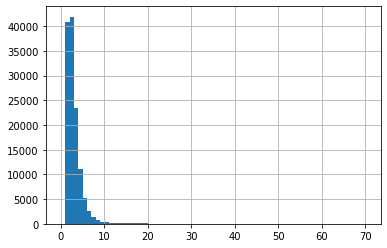

In [ ]:
print("Item Count", pd.unique(orders["item_count"]),"\nCount of unique item counts\n",orders["item_count"].value_counts()[:8] )
orderarr = orders["item_count"].hist(bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,20,30,40,70])

Grand Total [  7.6   8.7  14.4 ...  53.2  82.  138.5] 
Count of grand total of the orders
 9.5      2741
10.1     2726
8.4      2697
6.8      2659
9.0      2522
         ... 
67.6        1
69.4        1
81.2        1
48.8        1
138.5       1
Name: grand_total, Length: 1048, dtype: int64
Percentage of orders with less than 10.00 amount is 0.39


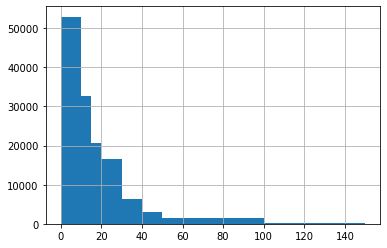

In [ ]:
print("Grand Total", pd.unique(orders["grand_total"]),"\nCount of grand total of the orders\n",orders["grand_total"].value_counts())
print("Percentage of orders with less than 10.00 amount is",round(orders.loc[orders["grand_total"] <= 10.00].shape[0]/orders.shape[0],2))
grandtotal = orders["grand_total"].hist(bins=[0,10,15,20,30,40,50,60,100,150])

In [ ]:
print("Driver Rating", pd.unique(orders["driver_rating"]),"\nCount for unique driver rating \n",orders["driver_rating"].value_counts())

Driver Rating [0. 5. 3. 4. 2. 1.] 
Count for unique driver rating 
 0.0    115339
5.0     15735
4.0      2142
3.0       889
1.0       765
2.0       352
Name: driver_rating, dtype: int64


https://seaborn.pydata.org/tutorial/aesthetics.html

In [ ]:
print("Delivery Distance", pd.unique(orders["deliverydistance"]),"\nCount of unique deliverydistance\n",orders["deliverydistance"].value_counts())

Delivery Distance [0.   1.68 3.87 ... 0.23 0.05 0.06] 
Count of unique deliverydistance
 0.00     55603
9.16       188
9.23       164
9.61       162
9.17       159
         ...  
19.81        1
15.11        1
0.17         1
16.64        1
0.06         1
Name: deliverydistance, Length: 1513, dtype: int64


In [ ]:
vendor_summary = orders.groupby(orders["VENDOR"]).agg({
    'customer_id':['count','nunique'],
    'payment_mode':['nunique'],
    'promo_code':['count'],
    'vendor_discount_amount':['sum'],
    'promo_code_discount_percentage':['mean'],
    'item_count':['median'],
    'grand_total':['median'],
    'driver_rating' : ['median'],
    'deliverydistance' : ['mean'],
    'preparationtime' :['mean'],
    'order_turnaround':['min','max','median']}).reset_index()

vendor_summary.columns = ['_'.join(col).strip() for col in vendor_summary.columns.values]
vendor_summary.rename(columns={'VENDOR_':'vendor_id'},inplace=True)

In [ ]:
vendor_summary.columns

Index(['vendor_id', 'customer_id_count', 'customer_id_nunique', 'payment_mode_nunique', 'promo_code_count', 'vendor_discount_amount_sum', 'promo_code_discount_percentage_mean', 'item_count_median', 'grand_total_median', 'driver_rating_median', 'deliverydistance_mean', 'preparationtime_mean', 'order_turnaround_min', 'order_turnaround_max', 'order_turnaround_median'], dtype='object')

Text(0, 0.5, 'Average turnaround time of vendors (seconds)')

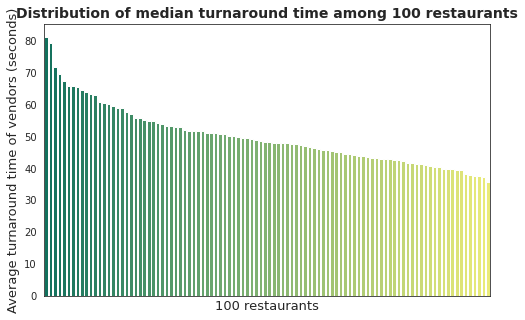

In [ ]:
#Distribution of customers
plt.figure(figsize=(8,5))
sns.set_style('white')
vendor_summary.sort_values(by="order_turnaround_median",inplace=True,ascending=False)
#sns.kdeplot(np.array(vendor_summary["customer_id_nunique"].values),clip = (0.0, max(vendor_summary["customer_id_nunique"])))
sns.barplot(y=vendor_summary["order_turnaround_median"]/60,x=vendor_summary["vendor_id"],palette='summer')
plt.title("Distribution of median turnaround time among 100 restaurants",fontsize=14, fontweight ="bold")
plt.xlabel("100 restaurants",fontsize=13)
plt.xticks([], [])
plt.ylabel("Median turnaround time of vendors (minutes)",fontsize=13)

Text(0, 0.5, 'Number of customers')

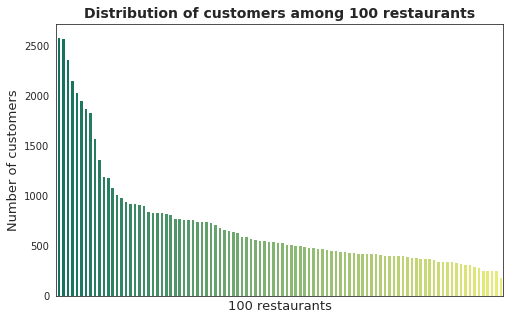

In [ ]:
#Distribution of customers
plt.figure(figsize=(8,5))
sns.set_style('white')
vendor_summary.sort_values(by="customer_id_nunique",inplace=True,ascending=False)
#sns.kdeplot(np.array(vendor_summary["customer_id_nunique"].values),clip = (0.0, max(vendor_summary["customer_id_nunique"])))
sns.barplot(y=vendor_summary["customer_id_nunique"],x=vendor_summary["vendor_id"],palette='summer')
plt.title("Distribution of customers among 100 restaurants",fontsize=14, fontweight ="bold")
plt.xlabel("100 restaurants",fontsize=13)
plt.xticks([], [])
plt.ylabel("Number of customers",fontsize=13)

Text(0, 0.5, 'Density of ratings')

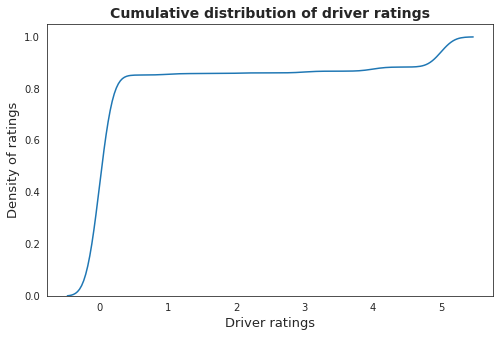

In [ ]:
plt.figure(figsize=(8,5))
sns.set_style('white')
sns.kdeplot(np.array(orders["driver_rating"].values), cumulative=True)
plt.title("Cumulative distribution of driver ratings",fontsize=14, fontweight ="bold")
plt.xlabel("Driver ratings",fontsize=13)
plt.ylabel("Density of ratings",fontsize=13)

Text(0, 0.5, 'Density of Delivery Distance')

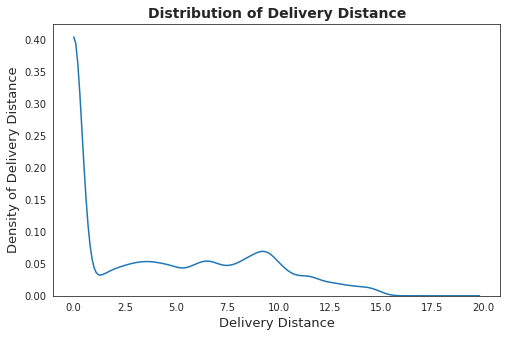

In [ ]:
plt.figure(figsize=(8,5))
sns.set_style('white')
sns.kdeplot(np.array(orders["deliverydistance"].values),clip = (0.0, max(orders["deliverydistance"])))
plt.title("Distribution of Delivery Distance",fontsize=14, fontweight ="bold")
plt.xlabel("Delivery Distance",fontsize=13)
plt.ylabel("Density of Delivery Distance",fontsize=13)

In [ ]:
train_cust_data = train_locations.merge(train_customers_dedup,left_on="customer_id",right_on="akeed_customer_id",how="left")
train_cust_data.drop(columns=["akeed_customer_id"],inplace=True)

vendors["key"] = 1
train_cust_data["key"] = 1
train_merged = train_cust_data.merge(vendors,on="key") #cartesian join

train_merged["CID X LOC_NUM X VENDOR"] = train_merged["customer_id"] + " X " + train_merged["location_number"].astype('str') + " X " + train_merged["id"].astype('str')
train_merged.shape

(5950300, 76)

Compute Haversine Distance
1. [scikit-learn haversine_distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html#:~:text=The%20Haversine%20(or%20great%20circle,the%20data%20must%20be%202.&text=A%20feature%20array.)

2. https://www.kaggle.com/code/speedoheck/calculate-distance-with-geo-coordinates/notebook


In [ ]:
def calculate_haversine(lon1, lat1, lon2, lat2):
    """
    All args must be of equal length
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    delta_lon = lon2 - lon1
    delta_lat = lat2 - lat1

    haversine_angle = np.sin(delta_lat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon/2.0)**2
    haversine_distance = 2 * 6371 * np.arcsin(np.sqrt(haversine_angle))
    return haversine_distance

In [ ]:
train_merged['haversine_distance'] = calculate_haversine(train_merged['longitude_x'],train_merged['latitude_x'],train_merged['longitude_y'],train_merged['latitude_y'])
train_merged['distance_diff']      = train_merged['haversine_distance'] - train_merged['serving_distance']
train_merged['distance_ratio']     = train_merged['haversine_distance'] / train_merged['serving_distance']
train_merged['latitude_diff']      = train_merged["latitude_x"] - train_merged["latitude_y"]
train_merged['longitude_diff']     = train_merged["longitude_x"] - train_merged["longitude_y"]
train_merged['latitude_sum']      = train_merged["latitude_x"] + train_merged["latitude_y"]
train_merged['longitude_sum']     = train_merged["longitude_x"] + train_merged["longitude_y"]


# Create target variable
# Merge feature data with order data to create the target variable
# Those with matches in the order table are considered as positive class since the customer has ordered from the vendor
orders = pd.read_csv("/content/drive/MyDrive/kaggle_data/orders.csv")
orders.drop_duplicates(subset=['CID X LOC_NUM X VENDOR'],inplace=True)
orders["target"] = 1
train_merged = pd.merge(train_merged,orders[['CID X LOC_NUM X VENDOR','target']],on='CID X LOC_NUM X VENDOR',how="left")
train_merged["target"].fillna(0,inplace=True)
    

Text(0, 0.5, 'Density of Haversine Distance')

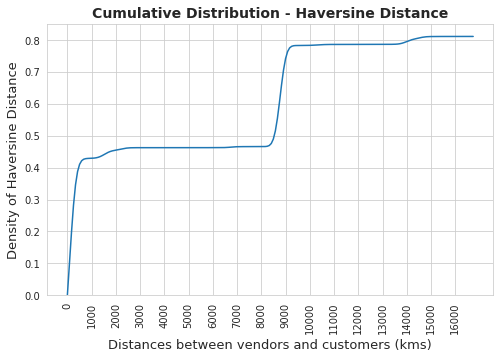

In [ ]:
plt.figure(figsize=(8,5))
sns.set_style('whitegrid')
sns.kdeplot(np.array(train_merged["haversine_distance"].values),clip=(0.0,max(train_merged["haversine_distance"])),cumulative=True)
plt.xticks(np.arange(min(train_merged["haversine_distance"]), max(train_merged["haversine_distance"])+1, 1000),rotation=90)
plt.title("Cumulative Distribution - Haversine Distance",fontsize=14, fontweight ="bold")
plt.xlabel("Distances between vendors and customers (kms)",fontsize=13)
plt.ylabel("Density of Haversine Distance",fontsize=13)

Text(0, 0.5, 'Density of Haversine Distance')

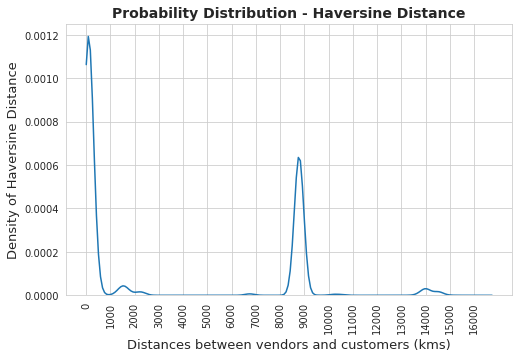

In [ ]:
plt.figure(figsize=(8,5))
sns.set_style('whitegrid')
sns.kdeplot(np.array(train_merged["haversine_distance"].values),clip=(0.0,max(train_merged["haversine_distance"])))
plt.xticks(np.arange(min(train_merged["haversine_distance"]), max(train_merged["haversine_distance"])+1, 1000),rotation=90)
plt.title("Probability Distribution - Haversine Distance",fontsize=14, fontweight ="bold")
plt.xlabel("Distances between vendors and customers (kms)",fontsize=13)
plt.ylabel("Density of Haversine Distance",fontsize=13)

Text(0, 0.5, 'Number of customers who had ordered')

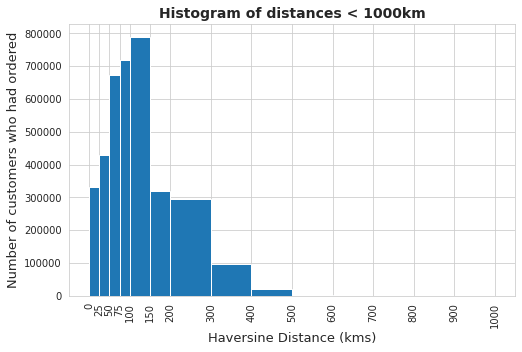

In [ ]:
#Count of locations per customer
import matplotlib.ticker as ticker
bins=[0,25,50,75,100,150,200,300,400,500,600,700,800,900,1000]
plt.figure(figsize=(8,5))
plt.hist(train_merged.loc[train_merged["haversine_distance"] <= 1000,"haversine_distance"],bins=bins) #there are maximum 30 values for a single customer
plt.xticks(np.arange(0, 1000, 100),rotation=90)
plt.title("Histogram of distances < 1000km",fontsize=14, fontweight ="bold")
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.FixedLocator((bins)))
plt.xlabel("Haversine Distance (kms)",fontsize=13)
plt.ylabel("Number of customers who had ordered",fontsize=13)

Actual delivery distance between the vendor and customer locations were not within the limits of the “serving distance”.

sample submission file

In [ ]:
sample_sub=pd.read_csv("/content/drive/MyDrive/kaggle_data/SampleSubmission (1).csv")    
print("sample_sub",sample_sub.shape) #
sample_sub.head()

sample_sub (1672000, 2)


,CID X LOC_NUM X VENDOR,target
0,Z59FTQD X 0 X 243,0
1,0JP29SK X 0 X 243,0
2,0JP29SK X 1 X 243,0
3,0JP29SK X 2 X 243,0
4,0JP29SK X 3 X 243,0


In [ ]:
train_full=pd.read_csv("/content/drive/MyDrive/kaggle_data/train_full.csv")
train_full[['CID','LOC_NUM','VENDOR']] = train_full['CID X LOC_NUM X VENDOR'].str.split(' X ',expand=True)
print("train_full",train_full.shape) #1.6M

train_full (5802400, 76)


In [ ]:
test_full=pd.read_csv("/content/drive/MyDrive/kaggle_data/test_full.csv")
test_full[['CID','LOC_NUM','VENDOR']] = test_full['CID X LOC_NUM X VENDOR'].str.split(' X ',expand=True)
print("test_full",test_full.shape) #1.6M

test_full (1672000, 75)


1. 10,000 unique customers in the test_full file.
2. No overlap (CID or 'CID X LOC_NUM X VENDOR') between train_full and test_full customers.
3. 40300 CID-LOCATION-VENDOR combos in the test_full file are without any meta data. Only vendor attributes are known.
4. 247 unique test customers are without metadata. Their gender, age and account status details are not available. The details of their location also remain unknown.
5. None of the 'CID' in test_full file is present in orders file.
6. All the 100 vendors are present in the test_full file.
7. 1631700 records have customer location coordinates available in test_locations file.
8. 1631700 records have customer details available in the test_customers file.

In [ ]:
#1
print("Total records in test full file",test_full.shape[0])
print("Total Customers in test full file",test_full["CID"].nunique())
#2
print("Total test customers in train file",test_full[test_full["CID"] .isin(train_full["customer_id"])].shape[0])
train_test_order_overlap = test_full[test_full['CID X LOC_NUM X VENDOR'] .isin(train_full['CID X LOC_NUM X VENDOR'])]
print("Same CID-LOCATION-VENDOR combos in train and test",train_test_order_overlap.shape[0])
#3
nodetail_customer = test_full[~test_full["CID"].isin(test_customers["akeed_customer_id"])]
print("Total CID-LOCATION-VENDOR combos without metadata",nodetail_customer.shape[0])
#4
print("Customers without customer or location metadata",nodetail_customer["CID"].nunique())

#5
print("Test - Unique Vendors :",test_full['VENDOR'].nunique())

#6
test_custloc_overlap =test_full[["customer_id","location_number"]].merge(test_locations[["customer_id","location_number"]], on=['customer_id','location_number'], how='left',indicator='outcome')
print("Records with customer location coordinates available",test_custloc_overlap[test_custloc_overlap["outcome"] == "both"].shape[0])

#7
test_customer_overlap = test_full[test_full['customer_id'] .isin(test_customers['akeed_customer_id'])]
print("Records with customer details available",test_customer_overlap.shape[0])

Total records in test full file 1672000
Total Customers in test full file 10000
Total test customers in train file 0
Same CID-LOCATION-VENDOR combos in train and test 0
Total CID-LOCATION-VENDOR combos without metadata 40300
Customers without customer or location metadata 247
Test - Unique Vendors : 100
Records with customer location coordinates available 1631700
Records with customer details available 1631700


#Solutioning Thoughts

1. Users ought to order from similar restaurants as other users living in the same neighbourhood. Similarity scores can be derived based on their geographical distances from all 100 vendors.

2. Additional vendor attribfeatures utes can be extracted from the orders table.

3. Clustering vendor-customer data is must and cluster-wise modelling to be done

4. 247 unique test customers are without metadata. Their gender, location and account status details are not available. These are examples of extreme cold start cases and has to be dealt appropriately.